In [1]:
%gui qt5
import ibapi
from tws_async_qt import TWSClient, iswrapper

In [2]:
# sample application
import datetime
from collections import defaultdict

class TWS(TWSClient):
    def __init__(self):
        TWSClient.__init__(self)
        self._reqIdSeq = 0
        self._histData = defaultdict(list)

    def getReqId(self):
        """
        Get new request ID (integer).
        """
        assert self._reqIdSeq
        newId = self._reqIdSeq
        self._reqIdSeq += 1
        return newId
    
    def popHistData(self, reqId):
        """
        Remove and return the historical data that was downloaded for the given reqId.
        """
        return self._histData.pop(reqId)
    
    @iswrapper
    def nextValidId(self, reqId: int):
        self._reqIdSeq = reqId

    @iswrapper
    def tickPrice(self, reqId: int,
            tickType: ibapi.ticktype.TickType,
            price: float,
            attrib: ibapi.common.TickAttrib):
        print('{} price {}'.format(reqId, price))

    @iswrapper
    def tickSize(self, reqId: int,
            tickType: ibapi.ticktype.TickType,
            size: int):
        print('{} size {}'.format(reqId, size))

    @iswrapper
    def historicalData(self, reqId: int, date: str, open: float, high: float,
            low: float, close: float, volume: int, barCount: int,
            WAP: float, hasGaps: int):
        self._histData[reqId].append((date, open, high, low, close, volume))
        
    @iswrapper
    def historicalDataEnd(self, reqId: int, start: str, end: str):
        print('Historical request {} is finished'.format(reqId))

        
if 'tws' in locals():
    tws.disconnect()
tws = TWS()
tws.connect('maxi', 7496, clientId=1)

ERROR:root:ERROR -1 2104 Market data farm connection is OK:hfarm
ERROR:root:ERROR -1 2104 Market data farm connection is OK:jfarm
ERROR:root:ERROR -1 2104 Market data farm connection is OK:usfuture
ERROR:root:ERROR -1 2104 Market data farm connection is OK:eufarm
ERROR:root:ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR:root:ERROR -1 2104 Market data farm connection is OK:usfarm.us
ERROR:root:ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR:root:ERROR -1 2106 HMDS data farm connection is OK:ilhmds
ERROR:root:ERROR -1 2106 HMDS data farm connection is OK:euhmds
ERROR:root:ERROR -1 2106 HMDS data farm connection is OK:fundfarm
ERROR:root:ERROR -1 2106 HMDS data farm connection is OK:ushmds


In [3]:
# create a stock contract
contract = ibapi.contract.Contract()
contract.symbol = 'TSLA'
contract.secType = 'STK'
contract.currency = 'USD'
contract.exchange = 'SMART'

In [4]:
# request historical bar data
reqId = tws.getReqId()
tws.reqHistoricalData(reqId, contract,
        endDateTime=datetime.datetime.utcnow().strftime('%Y%m%d %H:%M:%S UTC'),
        durationStr='30 D',
        barSizeSetting='1 hour',
        whatToShow='TRADES',
        useRTH=False,
        formatDate=1,
        chartOptions=None)

Historical request 488 is finished


In [5]:
# process data
import pandas as pd  
data = tws.popHistData(reqId)
df = pd.DataFrame.from_records(data)
df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']
df['datetime'] =  pd.to_datetime(df['datetime'])
# df.set_index('datetime', inplace=True)
df

,datetime,open,high,low,close,volume
0,2017-03-16 10:00:00,261.10,261.10,261.03,261.10,7
1,2017-03-16 11:00:00,261.24,262.30,261.12,262.05,12
2,2017-03-16 12:00:00,262.00,262.48,261.10,261.10,45
3,2017-03-16 13:00:00,261.50,264.40,261.10,264.00,901
4,2017-03-16 14:00:00,263.74,264.00,259.06,261.37,10356
5,2017-03-16 15:00:00,261.31,261.81,260.10,261.18,8325
6,2017-03-16 16:00:00,261.07,265.75,261.00,264.47,16538
7,2017-03-16 17:00:00,264.56,265.18,263.50,264.53,6016
8,2017-03-16 18:00:00,264.60,265.35,263.44,263.97,4648
9,2017-03-16 19:00:00,264.03,264.14,261.86,263.26,5728


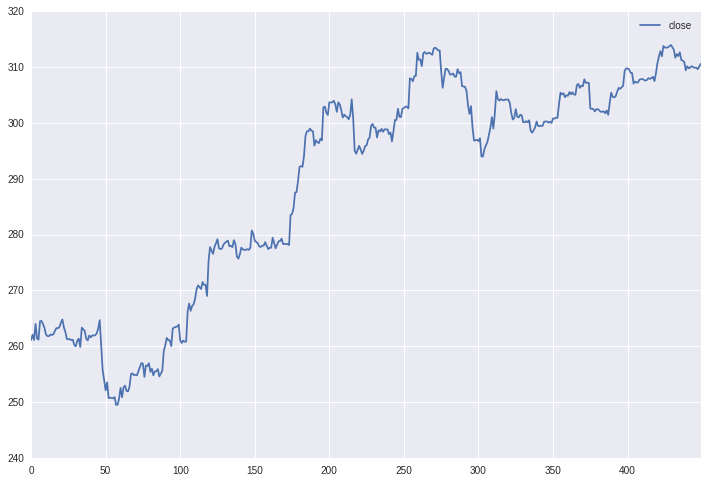

In [6]:
# plot data
%matplotlib inline
import seaborn as sns
df.plot(y='close', figsize=(12,8))

In [7]:
# subscribe to realtime tick data
reqId = tws.getReqId()
tws.reqMktData(reqId, contract, genericTickList='', snapshot=False,
        regulatorySnapshot=False, mktDataOptions=[])

489 price 310.2
489 size 3
489 price 310.59
489 size 2
489 price 310.59
489 size 1
489 size 3
489 size 2
489 size 1
489 size 42
489 price 310.17


In [8]:
# cancel realtime ticks
tws.cancelMktData(reqId)

In [9]:
# asyncio integration
import asyncio
import quamash

async def coro(seconds):
    print('starting coroutine...')
    await asyncio.sleep(seconds)
    print('coroutine finished')

loop = quamash.QEventLoop()
asyncio.set_event_loop(loop)

task = loop.create_task(coro(seconds=10))
loop.run_forever()

-1

starting coroutine...
coroutine finished
